<div class="usecase-title">Bin Fill Levels at Argyle Square</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>
<div class="usecase-duration"><b>Duration: </b>90 mins</div>
<div class="usecase-level"><b>Level: </b>Intermediate</div>
<div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>

<div class="usecase-section-header">Scenario</div>

 
1. I am planning an event at Argyle Square and need to know if there will be sufficient waste collection space in the bins, so need to know what conditions cause bin fill level to be higher.

2. I am a waste collection planner and need to know what conditions may cause bins to be at a fuller level.

<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Filtering of dataframes
- Use of date time to resample data by different time increments
- Create box plots from a dataframe to view datasets
- Create scatterplots from a dataframe to identify variable relationships
- Create pairplots from a dataframe to identify variable relationships
- Use Pearson correlation heatmap to identify linear variable relationships
- Use distance calculation to identify non-linear variable relationships
- Linear regression for predictive analysis
- Random Forest for predictive analysis
- Calculate feature importance, r-squared value and accuracy from predictive analysis

<div class="usecase-section-header">Why do we need to understand which variables impact bin fill levels?</div>

Prediction of bin fill levels can assist in solving two problems, that of issues relating to overflowing bins and that of rising costs to council for waste collection. If bin fill can be predicted, bins can be emptied in a timely manner,  ensuring there is space for new waste generated and reducing waste collection costs.</br>

Overflowing waste is a growing problem in modern cities. When bins overflow, it causes a liturgy of problems. These include streets cluttered with rubbish that cannot be placed in bins; rubbish washing into storm water drainage causing water pollution and an increase in bacteria, insects and vermin which cause health risks to humans <a href="#fn-1">[1]</a>. These factors also contrinute to a reduction in the wellbeing of inhabitants.</br>

In waste collection services, the main cost is in the distrance travelled by a truck to collect rubbish <a href="#fn-2">[2]</a>. In the situation where a container is known to be not full and predicted to have little rubbish added, the bin need not be collected. This means that the bin can be taken off the truck's route, reducing the distance travelled by the truck and thus saving costs in fuel, time and long term truck maintinence.
 



### RELEVANT DATASETS

[Blix Visits](https://data.melbourne.vic.gov.au/explore/dataset/blix-visits/information/)

- The Blix Visits data uses mobile phone counting <a href="#fn-3">[3]</a> to count the number of phones in a location. This dataset reports data at 3 minute intervals for each sensor; including a total count, dwell time and average dwell time (in minutes) of individual mobile phones. The blix sensors at Argle Square are the only ones of interest, so the data will be filtered at venueId 7780, Argyle Square. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Argyle Square Sound Stage Activity](https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-3/information/)
- The sound stage at Argyle Park has been fitted with three Elsys sensors <a href="#fn-3">[3]</a> to monotor movement on the stage. This data is reported every 3 minutes and includes an interger measurement value of motion and visit. In addition, the sensors also measure and report environmental data of temperature, humidity and light. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Netvox R718X Bin Sensor](https://data.melbourne.vic.gov.au/explore/dataset/netvox-r718x-bin-sensor/information/?disjunctive.dev_id)
- Netvox R718X measures distance using an ultrasonic ranging <a href="#fn-3">[3]</a>, which is used to calculate the bin fill level reported in the bin sensor data set. These levels are recorded every 15 minutes. This dataset aso reports the senros name, location and timedate data for the reading. Temperature and battery level are also recorded but not used in this use case. There are many bins across Argyle Square using this technology, but only bins from the area adjactent to the sound stage have been included in this investigation. This dataset is imported from the Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

### REQUIRED MODULES

In [277]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

# Import required modules
import requests
import numpy as np
import pandas as pd
import io
import folium
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import statistics

### IMPORT DATASETS

Import datasets using API v2.1 GET request with /exports/

In [61]:
from io import StringIO

# Function to collect datasets using API
def datasetcollect(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = " "
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [75]:
# Import stage activity dataset
dataset_id = 'meshed-sensor-type-3'
stage_activity_all = datasetcollect(dataset_id)
print(len(stage_activity_all))
stage_activity_all.head(3)

382460


,dev_id,sensor_name,time,temperature,humidity,light,motion,visit,vdd,lat_long
0,ers-55eb,NaN,2022-12-13T20:09:42+00:00,10.5,89,297,0,0,3638,NaN
1,ers-55ea,NaN,2022-12-13T20:26:03+00:00,10.6,88,136,0,0,3635,NaN
2,ers-55eb,NaN,2022-12-13T20:34:47+00:00,10.8,89,698,0,0,3638,NaN


In [263]:
# Import bin sensor dataset
dataset_id = 'netvox-r718x-bin-sensor'
bin_sensor_all = datasetcollect(dataset_id)
print(len(bin_sensor_all))
bin_sensor_all.head(3)

600546


,dev_id,time,temperature,distance,filllevel,battery,lat_long,sensor_name,fill_level
0,r718x-6778,2023-02-26T08:16:47+00:00,19.0,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
1,r718x-6f16,2023-02-26T08:18:10+00:00,19.9,202.0,74.0,3.6,"-37.8028794, 144.9662728",r718x-bin sensor 17,72.0
2,r718x-677d,2023-02-26T08:18:02+00:00,20.7,200.0,74.0,3.6,"-37.8021051, 144.9654523",r718x-bin sensor 11,72.0
3,r718x-677c,2023-02-26T08:18:11+00:00,18.8,297.0,62.0,3.6,"-37.8032818, 144.9661258",r718x-bin sensor 10,59.0
4,r718x-6773,2023-02-26T08:18:02+00:00,19.1,228.0,70.0,3.6,"-37.8022471, 144.9665562",r718x-bin sensor 5,68.0
5,r718x-6775,2023-02-26T08:25:51+00:00,19.6,302.0,61.0,3.6,"-37.8026209, 144.9660728",r718x-bin sensor 7,58.0
6,r718x-6f10,2023-02-26T08:26:23+00:00,23.0,65535.0,255.0,3.6,NaN,NaN,-8877.0
7,r718x-677e,2023-02-26T08:30:51+00:00,18.6,200.0,74.0,3.6,"-37.8025769, 144.9656557",r718x-bin sensor 12,72.0
8,r718x-6778,2023-02-26T08:31:47+00:00,18.9,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
9,r718x-677a,2023-02-26T08:35:54+00:00,19.3,215.0,72.0,3.6,"-37.8028672, 144.9657946",r718x-bin sensor 9,70.0


In [ ]:
# Import blix mobile phone counter dataset
dataset_id = 'blix-visits'
blix_phones_all = datasetcollect(dataset_id)
print(len(blix_phones_all))
blix_phones_all.head(3)

115506


,datetime,keys1,total,dwell,sensor_name,sensor_type,lat_long,avg_dwell
0,2022-08-25T22:00:00+00:00,8171,27,5697,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",3.0
1,2022-08-26T08:00:00+00:00,8171,115,42090,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",6.0
2,2022-08-26T02:00:00+00:00,7780,228,94848,Pedestrian Sensor-Argyle Sq,Mobile phone counting,"-37.8025805, 144.9656012",6.0


### DATA PREPPROCESSING

Preprocessing of datasets involves deleting unwanted columns, converting data types, resampling withing common dateframes, filtering rows in datasets by variables, resmapling using date time.

In [264]:
# Delete unwanted columns from datasets

# Drop columns from stage_activity dataframe
stage_activity = stage_activity_all[['dev_id','time','motion','visit','temperature','humidity','light']]
# Drop columns from stage_activity dataframe
bin_sensor_cols = bin_sensor_all[['dev_id','time','fill_level']]
# Drop columns from stage_activity dataframe
blix_phones = blix_phones_all[['datetime','keys1','total','dwell','avg_dwell']]

In [265]:
# check data types in columns
print("Data types in Stage activity")
print(stage_activity.dtypes)

print("Data types in Bin Sensor")
print(bin_sensor_cols.dtypes)

print("Data types in Blix Phones")
print(blix_phones.dtypes)

Data types in Stage activity
dev_id          object
time            object
motion           int64
visit            int64
temperature    float64
humidity         int64
light            int64
dtype: object
Data types in Bin Sensor
dev_id         object
time           object
fill_level    float64
dtype: object
Data types in Blix Phones
datetime      object
keys1          int64
total          int64
dwell          int64
avg_dwell    float64
dtype: object


In [266]:
# convert date time columns to date time type

stage_activity['date_time'] = pd.to_datetime(stage_activity['time'])
stage_activity = stage_activity.drop(['time'], axis=1)

bin_sensor_cols['date_time'] = pd.to_datetime(bin_sensor_cols['time'])
bin_sensor_cols = bin_sensor_cols.drop(['time'], axis=1)

blix_phones['date_time'] = pd.to_datetime(blix_phones['datetime'])
blix_phones = blix_phones.drop(['datetime'], axis=1)

In [267]:
#Check oldest and most recent dates in datasets

print("Date range in stage activity")
print(stage_activity["date_time"].min())
print(stage_activity["date_time"].max())

print("Date range in bin sensor")
print(bin_sensor_cols["date_time"].min())
print(bin_sensor_cols["date_time"].max())

print("Date range in blix phones")
print(blix_phones["date_time"].min())
print(blix_phones["date_time"].max())

Date range in stage activity
2022-11-29 06:05:16+00:00
2024-05-09 12:56:13+00:00
Date range in bin sensor
2023-02-26 08:16:37+00:00
2024-05-09 12:58:18+00:00
Date range in blix phones
2021-12-31 13:00:00+00:00
2024-05-09 13:00:00+00:00


In [268]:
# Drop rows so that all datasets have the same date range

stage_activity= stage_activity[(stage_activity['date_time'] > '2023-2-26') & (stage_activity['date_time'] <= '2024-3-26')]

bin_sensor= bin_sensor_cols[(bin_sensor_cols['date_time'] > '2023-2-26') & (bin_sensor_cols['date_time'] <= '2024-3-26')]

blix_phones= blix_phones[(blix_phones['date_time'] > '2023-2-26') & (blix_phones['date_time'] <= '2024-3-26')]


In [279]:
# Select unique locations
blix_location = blix_phones_all.drop_duplicates(subset=['keys1'])
bin_location = bin_sensor_all.drop_duplicates(subset=['sensor_name'])

# Drop na values
bin_location = bin_location.dropna(axis=0, how='any')
blix_location = blix_location.dropna(axis=0, how='any')


In [280]:

# Create separate columns for latitude and longitude
blix_location[['latitude','longitude']] = blix_location['lat_long'].str.split(', ',expand=True)
bin_location[['latitude','longitude']] = bin_location['lat_long'].str.split(', ',expand=True)

# Convert to geo-dataframe
bin_sensor = gpd.GeoDataFrame(bin_location, geometry=gpd.points_from_xy(bin_location['latitude'], bin_location['longitude']))
blix_sensor = gpd.GeoDataFrame(blix_location, geometry=gpd.points_from_xy(blix_location['latitude'], blix_location['longitude']))

In [291]:
# check locations of datasets
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.802533, 144.96567],zoom_start = 18)

# Add ped_count centroids locations
for i in range(0,len(bin_sensor)):
   folium.Marker(
      location=[bin_sensor.iloc[i]['latitude'], bin_sensor.iloc[i]['longitude']],
      popup='Name = {}'.format(bin_sensor['sensor_name'].values[0]),
      icon=folium.Icon(color="blue",prefix='fa', icon='trash-can')
   ).add_to(m)

# Add insect locations
for i in range(0,len(blix_sensor)):
   folium.Marker(
      location=[blix_sensor.iloc[i]['latitude'], blix_sensor.iloc[i]['longitude']],
      popup='Name = {}'.format(blix_sensor['keys1'].values[0]),
      icon=folium.Icon(color="pink",prefix='fa', icon='male'),
   ).add_to(m)
   
# A title can be added to the map, if desired.
m.get_root().html.add_child(folium.Element("<h3 align='center'>Sensor Locations Argyle Square</h3>"))

# Show the map
m

In [ ]:
# BIN DATASET PREPROCESSING
# Filter unwanted values from bin dataset 

# Keep only rows with bin sensors in the stage area
filtered_bin_sensor = bin_sensor_cols[bin_sensor_cols["dev_id"].isin(["r718x-6778", "r718x-6775","r718x-6f25","r718x-677e","r718x-6f31"])]
filtered_bin_sensor.head(3)

# Check max and min values in bin fill levels
# Max and min of filllevel column
print(filtered_bin_sensor['filllevel'].agg(['min', 'max']))

# Count the number of values greater than 100 in the bin fill coumns
more = len(filtered_bin_sensor[filtered_bin_sensor['filllevel']>100])

# Fnd percentage of values impacted  by value >100 in fill level
# Count the number of rows in the dataframe
total = len(filtered_bin_sensor)
#check the length of the dataframe
print(len(filtered_bin_sensor))
# Calculate the percentage of data that has values greater than 100
print(more/total)

# As only 0.0456% of data is impacted by data inaccuracies, make the decision to drop these rows from the table.

# Drop rows where bin fill column is greater than 100
filtered_bin_sensor = filtered_bin_sensor.drop(filtered_bin_sensor[filtered_bin_sensor['filllevel'] > 100].index)
# Check the length of the dataframe
len(filtered_bin_sensor)


min      0.0
max    255.0
Name: filllevel, dtype: float64
142624
0.0004276980031411263


142563

In [ ]:
# Look at locations of blix sensors and bins


In [ ]:
# BIN DATASET PREPROCESSING: RESAMPLE HOURLY FILLLEVEL MAX WITHOUT GROUPING BY BIN

# Set index to datetime column
filtered_bin_sensor.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_bin_sensor1 = filtered_bin_sensor.resample('H').filllevel.max()
grouped_bin_sensor1.head(3)

date_time
2023-02-26 08:00:00+00:00    74.0
2023-02-26 09:00:00+00:00    74.0
2023-02-26 10:00:00+00:00    74.0
Freq: H, Name: filllevel, dtype: float64

In [ ]:
# STAGE ACTIVITY DATASET PREPROCESSING: RESAMPLE HOURLY MAX WITHOUT GROUPING BY SENSOR

# Set index to datetime column
stage_a = stage_activity
stage_a.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_stage_activity = stage_a.resample('H').agg({'motion':'max','temperature':'mean','humidity':'mean','light':'mean'})
grouped_stage_activity.head(3)

,motion,temperature,humidity,light
date_time,,,,
2023-02-26 00:00:00+00:00,0.0,21.913333,56.900000,2080.466667
2023-02-26 01:00:00+00:00,1.0,23.612500,51.156250,2187.687500
2023-02-26 02:00:00+00:00,1.0,24.703226,49.322581,2069.096774


In [ ]:
# Merge grouped bin sensor and stage activity
merged_dataframe_A = pd.merge(grouped_bin_sensor1, grouped_stage_activity, on="date_time",how='outer')
merged_dataframe_A.head(3)

,filllevel,motion,temperature,humidity,light
date_time,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333


In [ ]:
# BLIX_PHONE DATASET PREPROCESSING: Filter unwated data

# Keep only rows with sensores in the stage area
filtered_blix_phone = blix_phones[blix_phones["keys1"].isin([7780])]
filtered_blix_phone.head(3)

,keys1,total,dwell,avg_dwell,date_time
32826,7780,223,44377,3.0,2023-02-26 07:00:00+00:00
32828,7780,237,88638,6.0,2023-02-26 06:00:00+00:00
32833,7780,186,72726,6.0,2023-02-26 05:00:00+00:00


In [ ]:
# BLIX PHONES DATASET ALREADY SAMPLED BY HOUR

# Set filtered_blix_phones index to datetime column
filtered_blix_phone.set_index('date_time', inplace=True)

In [71]:
# Merge dataframes

# Merge grouped stage activity, grouped bin sensor and grouped blix phones
# Drop dwell column as it is not needed
merged_dataframe = pd.merge(merged_dataframe_A, filtered_blix_phone[['total','avg_dwell']], on="date_time",how='outer')
merged_dataframe.head(3)

,filllevel,motion,temperature,humidity,light,total,avg_dwell
date_time,,,,,,,
2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,4.0
2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,4.0
2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,3.0


In [72]:
# Drop rows with na values
merged_dataframe = merged_dataframe.dropna(axis=0, how='any')

In [253]:
goagain = merged_dataframe
goagain = goagain.reset_index()
goagain["date"] = goagain["date_time"].dt.date
goagain["time"] = goagain["date_time"].dt.strftime('%H:%M')
goagain.head(3)


,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell,date,time
0,2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,4.0,2023-02-26,08:00
1,2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,4.0,2023-02-26,09:00
2,2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,3.0,2023-02-26,10:00


In [257]:
# Convert date columns to datetime type
goagain['date'] = pd.to_datetime(goagain['date'], format='%y%m%d') 
# Check variable types
goagain.dtypes

date_time      datetime64[ns, UTC]
filllevel                  float64
motion                     float64
temperature                float64
humidity                   float64
light                      float64
total                      float64
avg_dwell                  float64
date                datetime64[ns]
time                        object
dtype: object

In [255]:
goagain.head(3)

,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell,date,time
0,2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,4.0,2023-02-26,08:00
1,2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,4.0,2023-02-26,09:00
2,2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,3.0,2023-02-26,10:00


In [258]:
# Filter dataframe by hours
dayhours = goagain[(goagain['time'] > '07:00') & (goagain['time'] < '21:00')]
dayhours.head(3)

,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell,date,time
0,2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,4.0,2023-02-26,08:00
1,2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,4.0,2023-02-26,09:00
2,2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,3.0,2023-02-26,10:00


In [259]:
# Check out highest total values in dataframe
new = dayhours.sort_values('total',ascending=False)
new.head(20)

,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell,date,time
823,2023-04-01 16:00:00+00:00,74.0,0.0,11.647059,73.264706,3.794118,4279.0,2.0,2023-04-01,16:00
4847,2023-09-16 08:00:00+00:00,90.0,9.0,22.046429,40.071429,14.571429,489.0,5.0,2023-09-16,08:00
6959,2023-12-16 09:00:00+00:00,89.0,1.0,17.837500,66.958333,47.208333,467.0,8.0,2023-12-16,09:00
7127,2023-12-23 09:00:00+00:00,90.0,3.0,19.353333,63.033333,53.466667,435.0,5.0,2023-12-23,09:00
7103,2023-12-22 09:00:00+00:00,85.0,2.0,19.479310,58.206897,60.724138,407.0,6.0,2023-12-22,09:00
7126,2023-12-23 08:00:00+00:00,90.0,3.0,20.775758,59.242424,324.000000,399.0,9.0,2023-12-23,08:00
6934,2023-12-15 08:00:00+00:00,74.0,2.0,19.806667,60.000000,268.566667,388.0,7.0,2023-12-15,08:00
2138,2023-05-26 11:00:00+00:00,74.0,0.0,11.603448,78.034483,3.241379,384.0,3.0,2023-05-26,11:00
5184,2023-09-30 10:00:00+00:00,90.0,3.0,23.350000,31.281250,0.906250,379.0,3.0,2023-09-30,10:00
5039,2023-09-24 08:00:00+00:00,86.0,8.0,21.035294,43.911765,19.147059,363.0,5.0,2023-09-24,08:00


In [260]:
# Highest value has no other highvaues on that day, likely to be an error, so delete value
goagain = goagain[goagain['total'] < 500]
goagain.head(3)

,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell,date,time
0,2023-02-26 08:00:00+00:00,74.0,0.0,20.446154,67.038462,182.076923,177.0,4.0,2023-02-26,08:00
1,2023-02-26 09:00:00+00:00,74.0,0.0,19.538462,72.500000,5.807692,137.0,4.0,2023-02-26,09:00
2,2023-02-26 10:00:00+00:00,74.0,0.0,19.380000,74.966667,3.733333,77.0,3.0,2023-02-26,10:00


In [261]:
biggest = goagain.iloc[goagain["total"].idxmax()]
biggest

date_time      2023-09-24 13:00:00+00:00
filllevel                           90.0
motion                               1.0
temperature                    15.154839
humidity                       62.258065
light                           0.741935
total                               52.0
avg_dwell                            1.0
date                 2023-09-24 00:00:00
time                               13:00
Name: 5044, dtype: object

In [262]:
oneday = goagain[(goagain['date_time'] >= '2023-09-24 7:00:00+00:00') & (goagain['date_time'] <= '2023-09-24 13:00:00+00:00')]
oneday.head(20)

,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell,date,time
5038,2023-09-24 07:00:00+00:00,86.0,9.0,22.416667,40.433333,300.266667,498.0,5.0,2023-09-24,07:00
5039,2023-09-24 08:00:00+00:00,86.0,8.0,21.035294,43.911765,19.147059,363.0,5.0,2023-09-24,08:00
5040,2023-09-24 09:00:00+00:00,90.0,0.0,19.440000,48.133333,1.033333,205.0,5.0,2023-09-24,09:00
5041,2023-09-24 10:00:00+00:00,90.0,0.0,18.109091,51.757576,0.787879,267.0,5.0,2023-09-24,10:00
5042,2023-09-24 11:00:00+00:00,74.0,1.0,17.183871,55.516129,0.806452,165.0,5.0,2023-09-24,11:00
5043,2023-09-24 12:00:00+00:00,90.0,2.0,16.183871,58.645161,0.774194,80.0,4.0,2023-09-24,12:00
5044,2023-09-24 13:00:00+00:00,90.0,1.0,15.154839,62.258065,0.741935,52.0,1.0,2023-09-24,13:00


As this investigation aims to predict bin fill levels during events, the dataframe will be filtered to only include the times when the total number of people is greater than 200.

In [131]:
# Select onnly when there are more than 200 people at Argyle square
event = merged_dataframe[merged_dataframe['total'] > 250] 
print(len(event))
event.head(3)

778


,filllevel,motion,temperature,humidity,light,total,avg_dwell
date_time,,,,,,,
2023-03-02 01:00:00+00:00,74.0,0.0,21.277419,58.225806,2181.806452,304.0,5.0
2023-03-02 02:00:00+00:00,74.0,0.0,21.887500,56.625000,2249.833333,263.0,3.0
2023-03-02 05:00:00+00:00,74.0,1.0,21.110000,62.500000,1609.233333,265.0,5.0


All data is in one table. Data now needs to be investigated to check the range of values in each column. This will be done using a series of box and whiskar plots. Bos and whiskar plot are choosen as they give the range, median and show the distribution of the data, as well as visualising the presence of outiers.

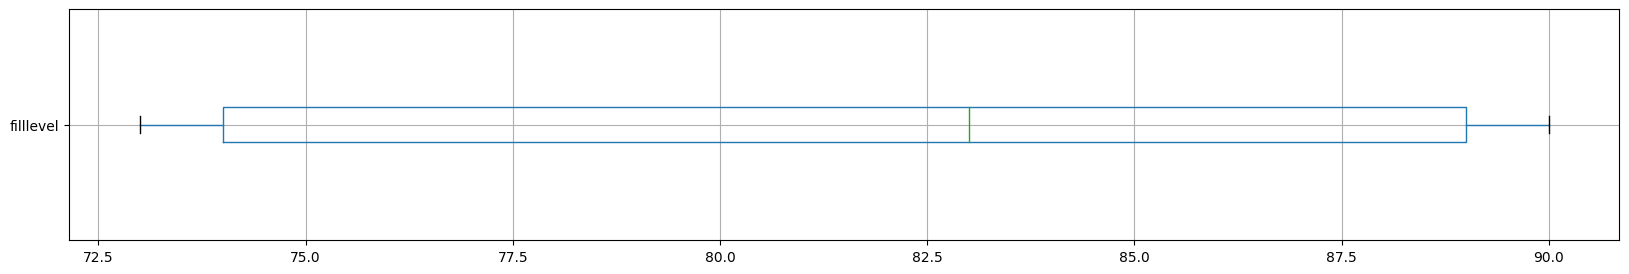

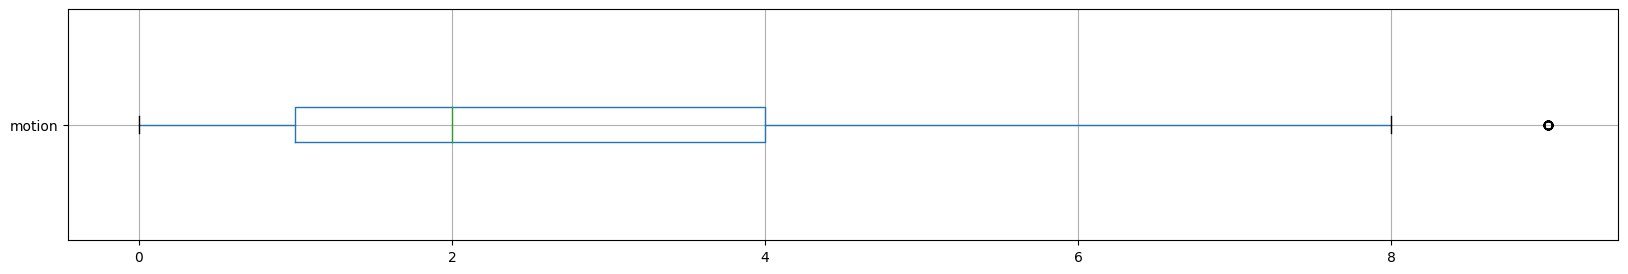

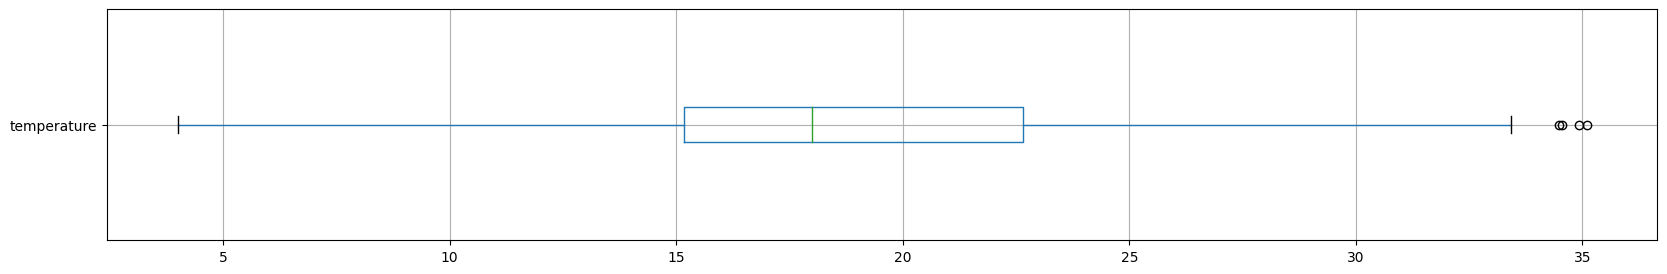

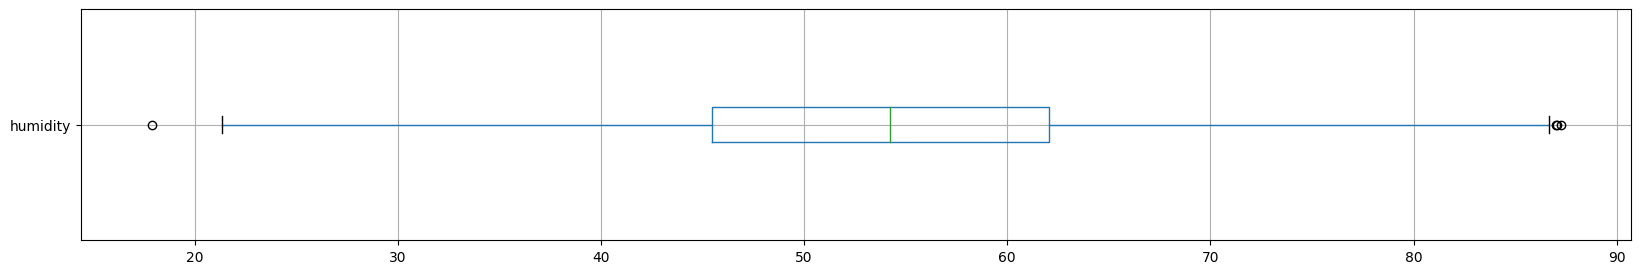

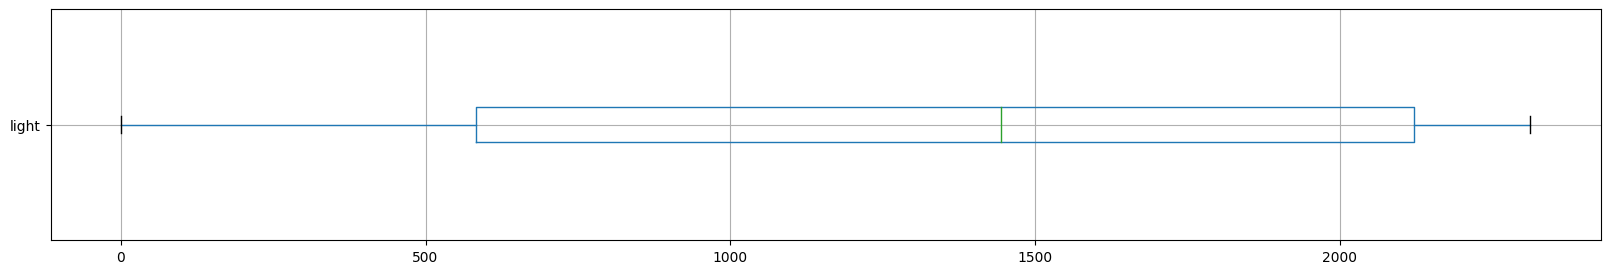

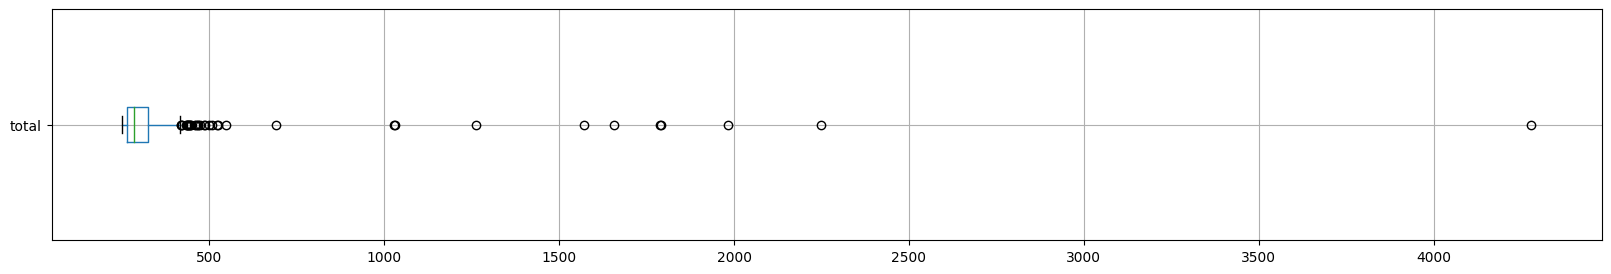

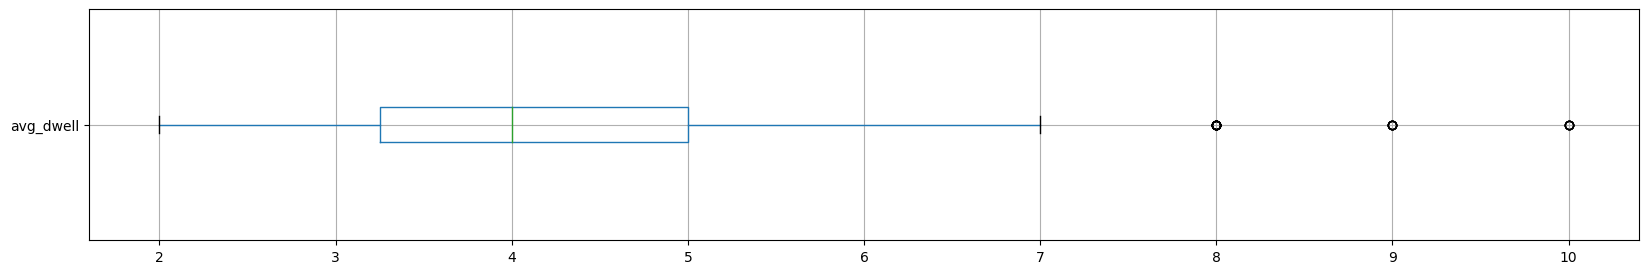

In [132]:
# Use box plots to check for any unexpected values in data

# Iterate over columns and create a horizontal box plot for each one
for column in event:
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure()
    event.boxplot([column], vert=False)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

The box plots show the disributions of the data in each column. All distributions are within expected ranges for the data types so no action will be taken on outliers.

### FEATURE CORRELATION

A scatterplot is used to identify if there is a relationshsips between bin fill level and time.

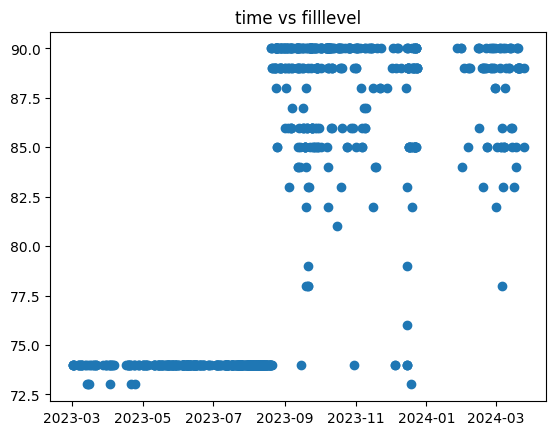

In [133]:
# Create scatter plots of datetime vs all other variables
# Add index column
event = event.reset_index()

# Create a plot of time vs filllevel
plt.scatter(event['date_time'], event['filllevel'])
plt.title("time vs filllevel")
ax = plt.gca()

plt.show()


From the scatterplots against time, bin fill levels remained below 75% in 2023 between March and August. From September 2023 to mid March, bin fill levels have much more variation. For this reason, data prio to 2023 will be deleted from the dataset.

In [185]:
# Delete data prior to 2023 September
summer_event = event[event['date_time'] >= '2023-8-23'] 
print(len(summer_event))
summer_event.head(3)

410


,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell
368,2023-08-23 03:00:00+00:00,89.0,1.0,18.413333,47.800000,1948.966667,372.0,5.0
369,2023-08-23 04:00:00+00:00,89.0,0.0,17.345161,50.516129,1295.032258,259.0,4.0
370,2023-08-23 07:00:00+00:00,89.0,1.0,15.446667,55.800000,173.066667,263.0,4.0


In [186]:
print("Date range in stage activity")
print(summer_event["date_time"].min())
print(summer_event["date_time"].max())

Date range in stage activity
2023-08-23 03:00:00+00:00
2024-03-25 02:00:00+00:00


In [189]:
new = summer_event.groupby(by=['filllevel', 'date_time'])
print(len(new))
new.head(3)

410


,date_time,filllevel,motion,temperature,humidity,light,total,avg_dwell
368,2023-08-23 03:00:00+00:00,89.0,1.0,18.413333,47.800000,1948.966667,372.0,5.0
369,2023-08-23 04:00:00+00:00,89.0,0.0,17.345161,50.516129,1295.032258,259.0,4.0
370,2023-08-23 07:00:00+00:00,89.0,1.0,15.446667,55.800000,173.066667,263.0,4.0
371,2023-08-23 08:00:00+00:00,90.0,0.0,14.406250,59.500000,2.937500,286.0,3.0
372,2023-08-23 22:00:00+00:00,90.0,1.0,10.612121,77.242424,2113.393939,284.0,4.0
...,...,...,...,...,...,...,...,...
773,2024-03-21 06:00:00+00:00,89.0,3.0,19.918750,52.843750,897.406250,377.0,3.0
774,2024-03-22 01:00:00+00:00,89.0,3.0,25.703030,43.000000,2292.878788,330.0,5.0
775,2024-03-22 02:00:00+00:00,89.0,4.0,23.437931,49.172414,2282.689655,322.0,3.0
776,2024-03-25 01:00:00+00:00,85.0,2.0,22.950000,48.535714,2117.142857,280.0,5.0


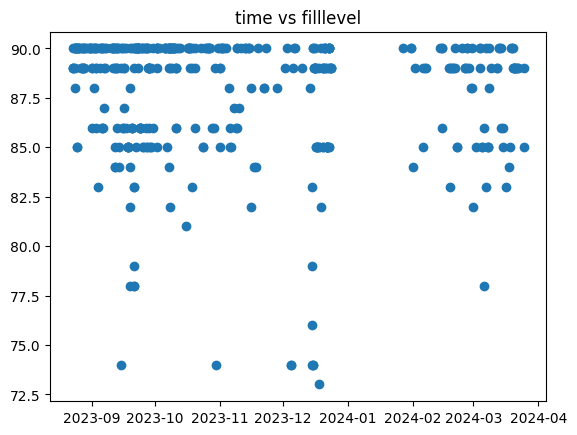

In [135]:
# Recheck plot of time vs fill level
plt.scatter(summer_event['date_time'], summer_event['filllevel'])
plt.title("time vs filllevel")
ax = plt.gca()

plt.show()

A Pairs plot will be used to visualise the relationships between numeric variables. To better understand these relationships, Z-score standardisation will be carried out on all columns. As some data columns have very large values and others very small, these is a need to standardise the data. Z-score scaling is used as some data columns have small outliers (which make sense within their datasets). This ensures all features have a mean of 0 and a standard deviation of 1. This also means that when used in modelling the values of one feature will not skew the model results. 

In [136]:
# Set date_time as index as cannot apply z-score function to it
summer_event.set_index('date_time', inplace=True)
# Apply z-score standardisation to all columns
summer_event_standard = summer_event.apply(zscore)
summer_event_standard.head(3)

,filllevel,motion,temperature,humidity,light,total,avg_dwell
date_time,,,,,,,
2023-08-23 03:00:00+00:00,0.369115,-0.860234,-0.642473,-0.089523,0.583068,0.187649,0.185210
2023-08-23 04:00:00+00:00,0.369115,-1.241527,-0.860111,0.124785,-0.201844,-0.362103,-0.458316
2023-08-23 07:00:00+00:00,0.369115,-0.860234,-1.246927,0.541695,-1.548530,-0.342643,-0.458316


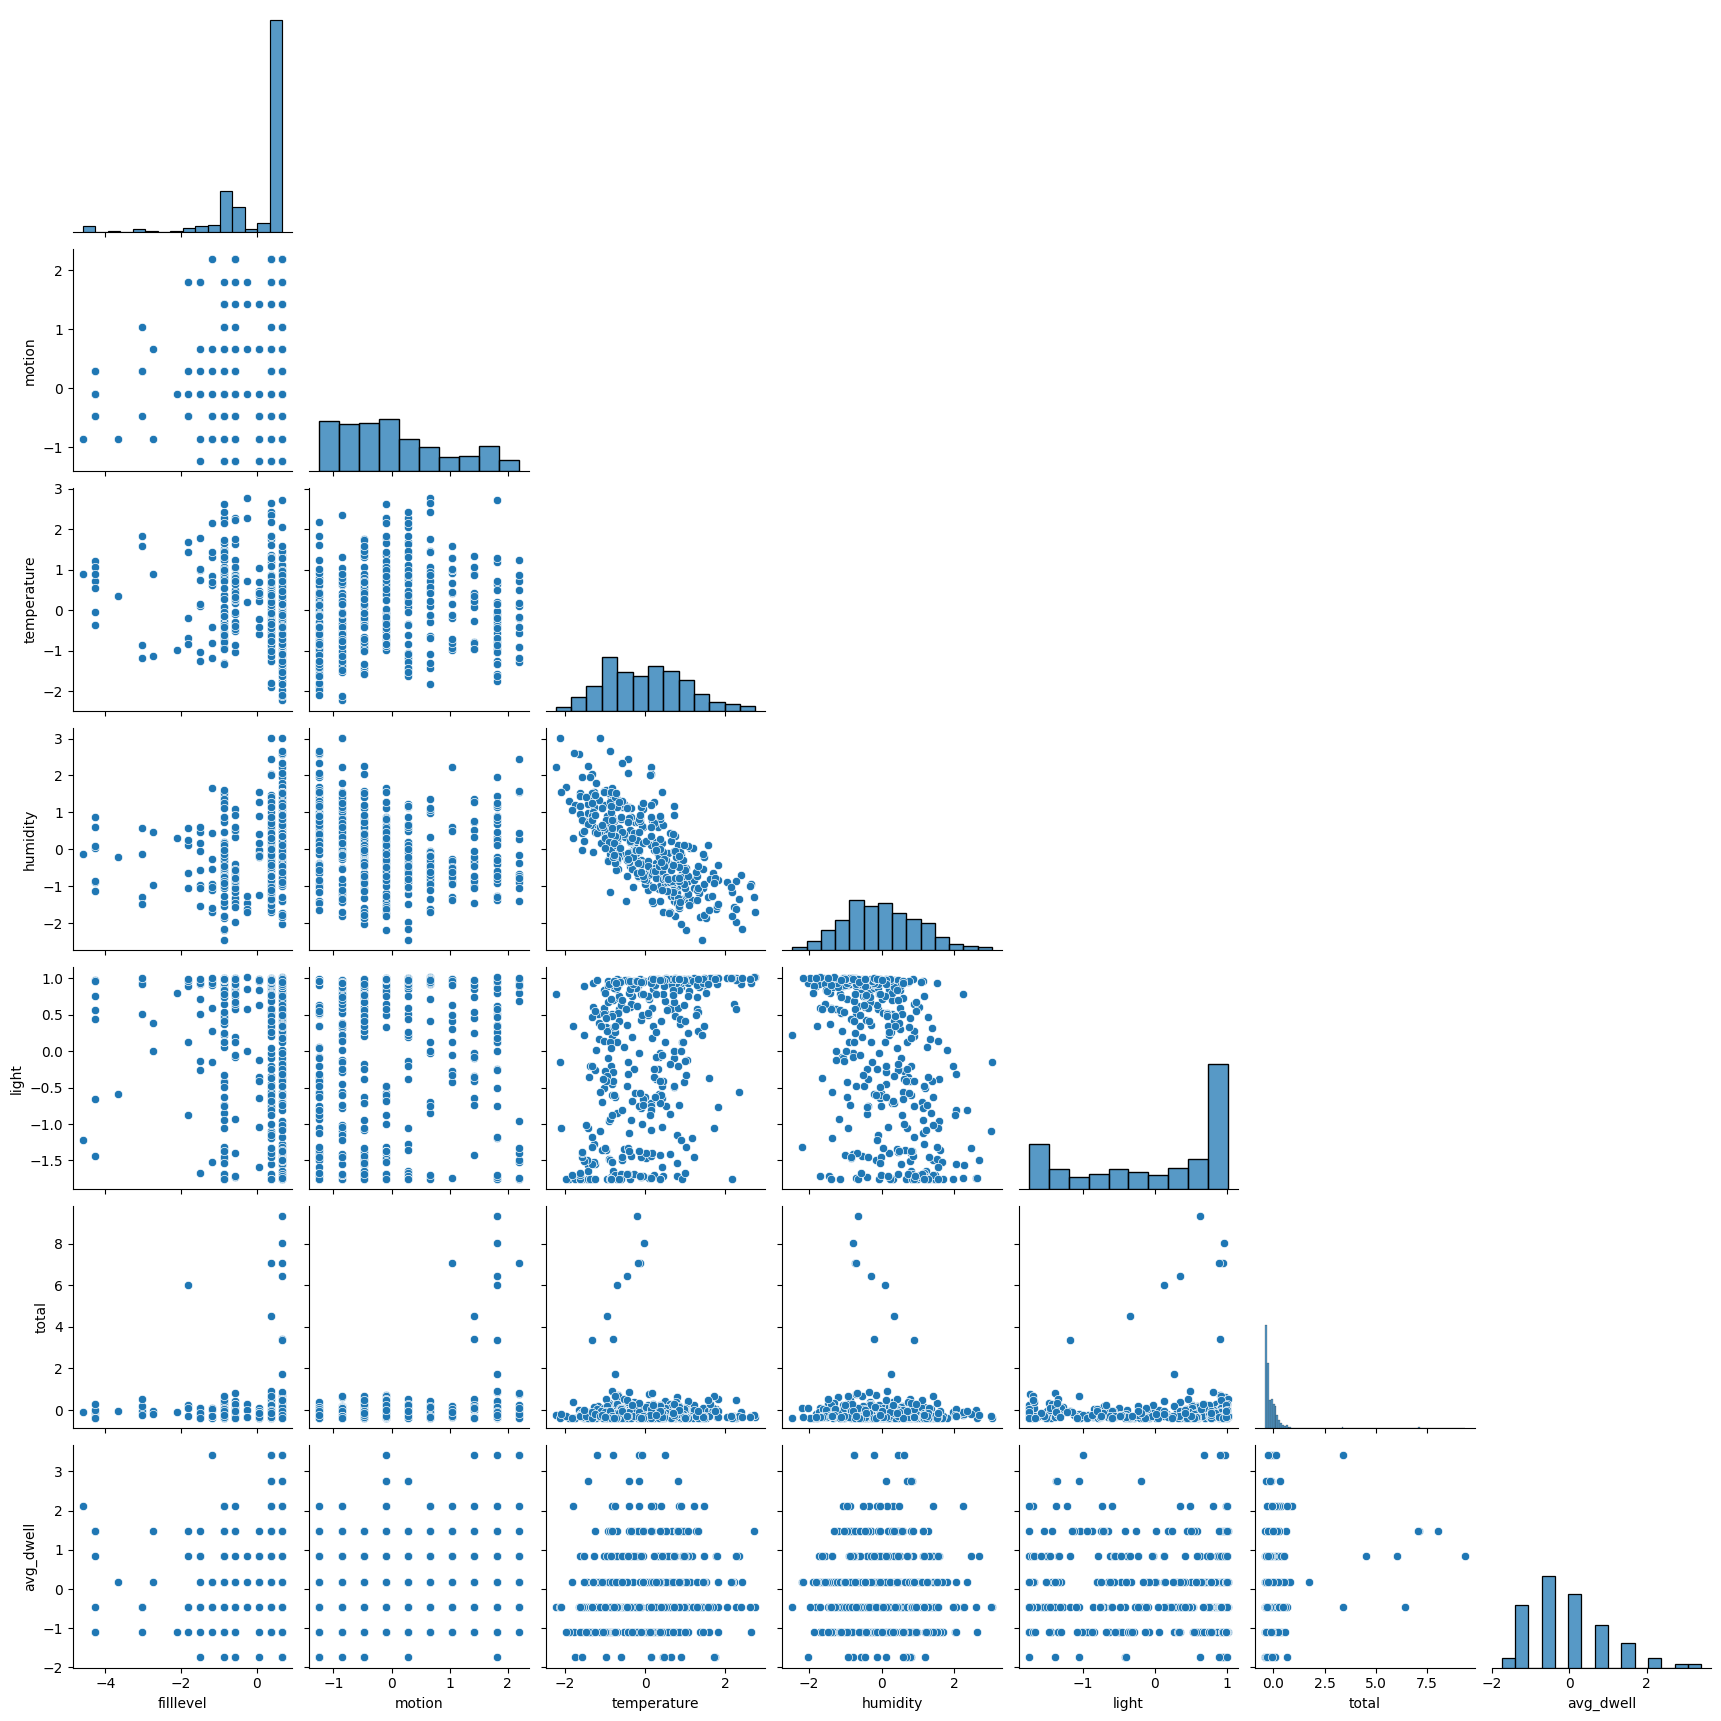

In [137]:
# Create a pairsplot to look at relationships between numerical variables
sns.pairplot(summer_event_standard, corner=True)
plt.show()

The pairs plot shows a relationship between numerical variables. Temperature and humidity have the strongest linear reationship, followed by light with temperature and light with humidity. The goal of this task is to find relationships between sensor data and bin fill levels. High total numbers of people also appear to have a relationship with bin fill level; every high value for attendeers except for one correlated to a high bin fill level.

Int the correlation heatmap, Pearson correlation is used to determine extent of linear relationship between each pair of variables. This is because several of the variables are seen to have a strong linear relationship and this needs to be measured.

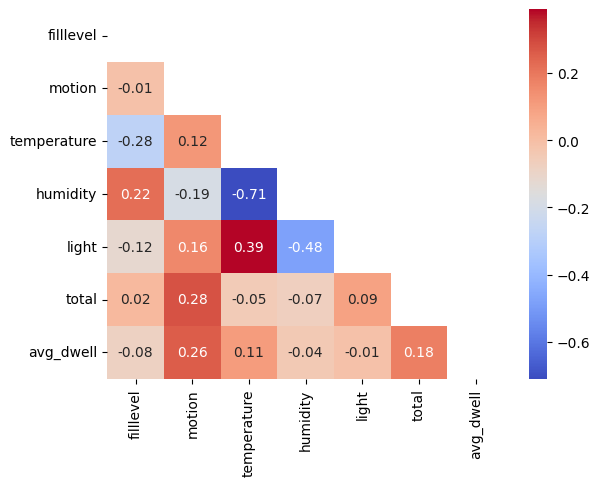

In [138]:
# Calculate correlation heatmap for all columns
matrix = summer_event_standard.corr(method = 'pearson').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(matrix, annot=True, cmap=color, mask=mask)

plt.show()

The correlation heatmap shows the extent of the linear relationship between variables. The strongest linear relaionship is shown to be between total and dwell data. Humidity and temperature also have a strong linear correlation, followed by light and temperature. In this investigation the focus is on the relationship between fill level and other variables. The highest linear relationship including bin fill level is between fill level and time, at 0.8 positive linear relationship. Next is temperature and bin fill level, with has a medium negative linear correlation of 0.34, followed by other weather related variables. Motion, dwelling and total are seen to have weak negative linear relationships with bin fill level. Of note, bin fill level and total are seen to have a very weak negative relationship.

As few variables exhibit a strong linear relationship with bin fill level in the heatmap or pairplot, the existance of non-linear relationships should also be measured. The Distance Correlation uses the dcor package to help capture the extent of non-linear correlation between variables and bin fill level. As bin fill level is the main variable of interest, measurements of each varaibles correlation to fill level will be calculated. It is important to note that date time is not supported in the distance calculation function.

In [139]:
# Calculate distance correlation between numerical variables and bin fill level (Datetime not supported)
print("filllevel and total =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['total']))
print("filllevel and avg_dwell =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['avg_dwell']))
print("filllevel and motion =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['motion']))
print("filllevel and temperature =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['temperature']))
print("filllevel and humidity =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['humidity']))
print("fillevel and light =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['light']))


filllevel and total = 0.11329265199868836
filllevel and avg_dwell = 0.10457769882933886
filllevel and motion = 0.11242902529074322
filllevel and temperature = 0.32752361830690785
filllevel and humidity = 0.26241949123613756
fillevel and light = 0.14749167719499412


The strongest non-linear correlations measured remain between bin fill level and weather variables of temperature, humidity and light. The total, average dwelling and motion all have around 10% correltaion with bin fill level. This means there is likely a non-linear correlation bwteen these variables and the bin fill level.

### FEATURE ENGINEERING

An important role of exploratory data analysis is identifying feature correlation. The results of this correlation is used in the selection of features on which to carry out modelling processes. Correlated features need to be removed prior to predictive modelling taking place. This can be done in several ways, including PCA and domain knowledge. 

PCA feature selection uses a mathematic transformation to project the variables to a new co-ordinate system <a href="#fn-4">[4]</a>. This apporach selects the most important attributes that best explain the variance of the dependent variable, removng correlation between features. However, the components no longer represent individual data (temperature, total, motion) etc, insetad become a combination which is not clearly identfiable. This means that it would be much harder to explain how the modelling works and to make future predictions. For this reason, the use of PCA is not appropriate for this use case.

Domain knowledge is determined as the best method for feature selection in this use case. This allows doamin knowleedeg fo relationships to be used to reduce fatures used in modelling to make mor uable prediction models.

The features choosen to be removed are light and humidity, due to their strong linear relationships with temperature. Time data will also be removed from the modelling data, as time period is specified as over summer not per date.

In [149]:
# Select required features for modelling
model_dataframe = summer_event_standard[['filllevel','motion','temperature','total']]
# Drop datetime index and replace with number index
model_dataframe = model_dataframe.reset_index(drop=True)
print(len(model_dataframe))
model_dataframe.head(3)

410


,filllevel,motion,temperature,total
0,0.369115,-0.860234,-0.642473,0.187649
1,0.369115,-1.241527,-0.860111,-0.362103
2,0.369115,-0.860234,-1.246927,-0.342643


Date range in stage activity


KeyError: 'date_time'

Text(0.5, 1.0, 'Total People and bin fill level')

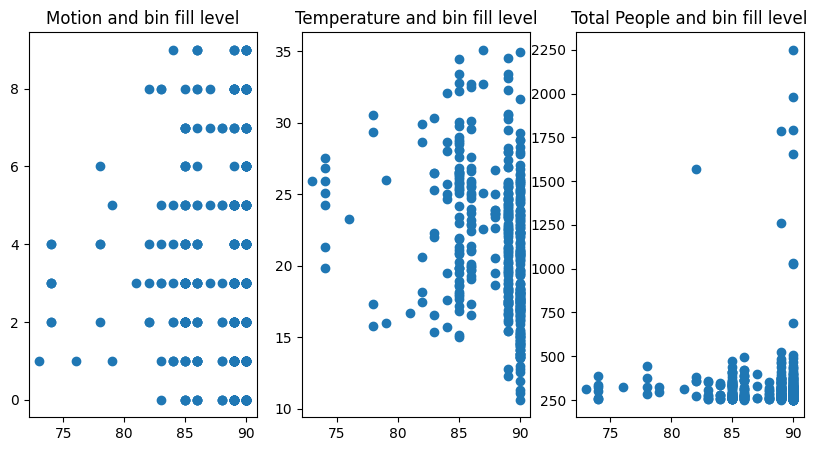

In [178]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':100})
fig, ax = plt.subplots(1,3)
ax[0].scatter(summer_event['filllevel'], summer_event['motion'])
ax[0].set_title("Motion and bin fill level")
ax[1].scatter(summer_event['filllevel'], summer_event['temperature'])
ax[1].set_title("Temperature and bin fill level")
ax[2].scatter(summer_event['filllevel'], summer_event['total'])
ax[2].set_title("Total People and bin fill level")

### SYNTHETIC DATA

In [ ]:
# Initiate SMOTE to resample data
sm = SMOTE(random_state=42)

# Set the x and y variables from the whole dataset
X = relations.drop(["bus_stop"], axis=1)
y = relations["bus_stop"]

# Use SMOTE resampling to increase but stop data with synthetic data
X, y = sm.fit_resample(X, y)

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

### PREDICTIVE MODELLING

The main issue in predictive modelling for this use case is the small dataset size. To solve the problem of little data, research was completed to try to find open datasets conatining smart bin fill level data, stage use data, pedestrian counts and temperature but no datasets of corresponding locations open source could be found. The Australian Government data portal <a href="#fn-5">[5]</a> currenlty holds data on smart bins for Wyndham and Mildura areas. Pedestrian data is availible for Liverpoool, Ballarat, City of Casey, City of Sydney and Greater Geelong. Stage use data could not be found at any locations. As it is evident that there is no overlap between these datasets, additional data cannot be found within Australia. Kaggle <a href="#fn-6">[6]</a> was also searched, again reporting no appropriate international datasets. As it is assumed over time that the datasets used in this use case will increase as sensors as still in place, predictive modelling will become more accurate as data sets increase.

A regression algorithm will be used to predict bin fill levels from the prepared dataset. Regression is choosen as it makes predictions on continuos variables with known measurements of the dependent variable, as in the case of bin fill levels. Support Vector Regression (SVR) finds the best fit to predeict target variables without overfitting data. In addition, it allows kernals of different shape to be used <a href="#fn-7">[7]</a>. As there is no obvious relationship between the target bin data variable and the predictor variables; linear, polynomial and radial basis function kernals can all be compared to find which gives the best model for prediction.

Model performance will be evaluated using accuracy, coefficient of determination (r-squared value) and root mean squared error (rmse). The accuracy of the model is calculated by dividing the total number of times the prediction exactly matches the data value in the table and dividing by the total number of predictions. The r-squared value indicates how much variation in the target variabe is eplained by the dataset, while the rmse is a measure of the how far the prediction estmates are from the actual data values <a href="#fn-8">[8]</a>.

#### PREDICTIVE MODELLING Preprocessing

First, a function will be created to calculate accuracy. Data will then be split into a test-train split, with 30% of data held as the test set and 70% of data used to train the model.

In [143]:
# Make function to analyse accuracy of predictions
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = round(correct_predictions/len(y_true)*100,2)
    print(f"accuracy: {accuracy}%")

In [144]:
# Set the x and y variables. Drop date_time as it is not supported by linear or random forest
X = model_dataframe_standard.drop(["filllevel"], axis=1)
y = model_dataframe_standard["filllevel"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [145]:
# Create function for hyperparameter tuning with random search
def hyperparameter_tune(svr, parameters, iterations, X, y):
    randomSearch = RandomizedSearchCV(
        svr,
        param_distributions=parameters,
        n_jobs=-1,
        n_iter=iterations,
        cv=2
    )
    # Fit the model and find the best hyperparameters
    randomSearch.fit(X_train,y_train)
    return randomSearch.best_params_

PREDICTIVE MODEL - Linear Regression

Linear regression assumes an underlying linear relationship between the features of interest and bin fill level. A randomised search will be carried out to tune the parameters for the SVR model with linear kernel. The best parameters will then be passed into the model and the model performance evaluated.

In [ ]:
# Hyperparameter tuning
# Initiate instance of SVR
svr  = SVR ()

# Set parameters for random search to test
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["linear"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

# Call random search function on linear SVR
best_params = hyperparameter_tune(svr, parameters, iterations=10, X=X_train, y=y_train)
# Print results of random search
print("Best hyperparameters for linear:", best_params)

Best hyperparameters for linear: {'kernel': 'linear', 'gamma': 0.01, 'degree': 3, 'C': 0.01}


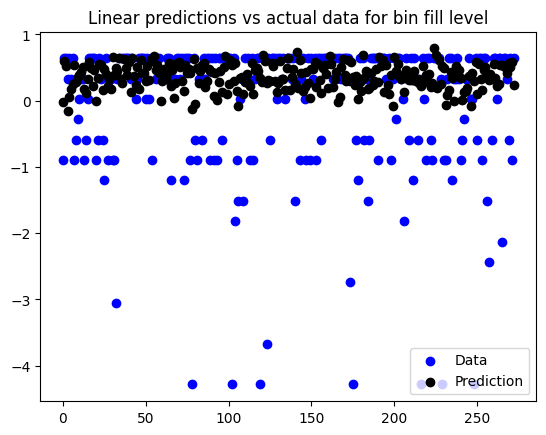

accuracy: 0.0%
r2: -0.07
rmse: 1.06


In [146]:
# Modelling
# Initiate SVR model with best parameters
model = SVR(kernel="linear",C=0.01,degree=7,gamma=1)
# Fit the model with the training data
model.fit(X_train, y_train)
# Make predictions with the data
predictions = model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(predictions)), predictions, color='black',label='Prediction')
plt.title("Linear predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, predictions)

# Calculate the r2 score
r2_score = round(metrics.r2_score(y_test, predictions),2)
print(f'r2: {r2_score}')

# Calculate the rmse
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2)
print(f'rmse: {rmse}')

The linear regression model aims to predict the standardised values in the bin fill level column from the linear relationship from the standardsed variables of temperature, total and motion. The scatterplot compares the model predictions to actual values. From this plot it is seen that the SVR with linear regression kernal has a tendency to return below average bin fill levels, with most predictions below the mean of 0. Of note there are many values redicted above 1.5 standard deviations above the mean but none below 1.5 standard deviations from the mean.</br>

Model performance is evaluated using accuracy, r-squared and rmse calculations. The SVR with linear kernal model made 0 accurate predictions. The r-squared value is also very low, at 0.06, meaning that the model explains very little of the variation in the bin fill level variable around its mean. The rmse value at 97% is high, indicating that prediction estimates are all far from actual data values.These model performance measurements show the model is working poorly to predict bin fill levels from data given.


PREDICTIVE MODEL - Polynomial Regression

Polynomial regression assumes a non-linear relationship between the features of interest and bin fill level. As with the linear model, a randomised search will be carried out to tune the parameters for the SVR model with polynomial kernel. The best parameters will then be passed into the model and the model performance evaluated.

In [ ]:
# Hyperparameter tuning
# Set parameters for random search to test
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["poly"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

# Call random search function on polynomial SVR
best_params = hyperparameter_tune(svr, parameters, iterations=10, X=X_train, y=y_train)
# Print results of random search
print("Best hyperparameters for polynomial:", best_params)

KeyboardInterrupt: 

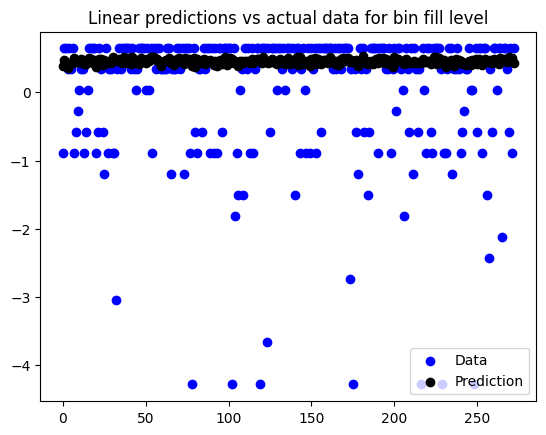

accuracy: 0.0%
r2: -0.18
rmse: 1.11


In [147]:
# Modelling
# Initiate SVR model with best parameters
model = SVR(kernel="poly",C=0.01,degree=1,gamma=0.01)
# Fit the model with the training data
model.fit(X_train, y_train)
# Make predictions with the data
predictions = model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(predictions)), predictions, color='black',label='Prediction')
plt.title("Linear predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, predictions)

# Calculate the r2 score
r2_score = round(metrics.r2_score(y_test, predictions),2)
print(f'r2: {r2_score}')

# Calculate the rmse
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2)
print(f'rmse: {rmse}')

PREDICTIVE MODEL - Radial Basis Function Regression

Radial basis function regression assumes a gaussian relationship between the features of interest and bin fill level. As with the models above, randomised search will be carried out to tune the parameters for the SVR model with an rbf kernel. The best parameters will then be passed into the model and the model performance evaluated.

In [ ]:
# Hyperparameter tuning
# Set parameters for random search to test
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["rbf"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

# Call random search function on rbf SVR
best_params = hyperparameter_tune(svr, parameters, iterations=10, X=X_train, y=y_train)
# Print results of random search
print("Best hyperparameters for rbf:", best_params)

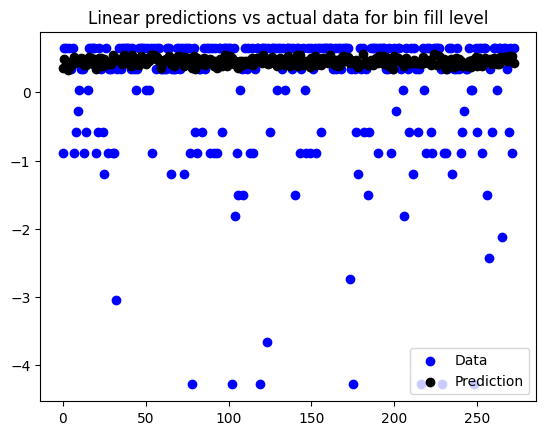

accuracy: 0.0%
r2: -0.17
rmse: 1.11


In [148]:
# Modelling
# Initiate SVR model with best parameters
model = SVR(kernel="rbf",C=0.01,degree=1,gamma=0.01)
# Fit the model with the training data
model.fit(X_train, y_train)
# Make predictions with the data
predictions = model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(predictions)), predictions, color='black',label='Prediction')
plt.title("Linear predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, predictions)

# Calculate the r2 score
r2_score = round(metrics.r2_score(y_test, predictions),2)
print(f'r2: {r2_score}')

# Calculate the rmse
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2)
print(f'rmse: {rmse}')

### FINDINGS

The findings of this investigation into the variables effecting bin fill level at Argyle Square are inconclusive. It was expected that the total number of people would impact the bin fill level. However, Pearson correlation found a very weak negaive association, while the distance calcution also found a very weak correlation. 


 This suggests that the data set is not yet large enough to be used in predictive anaylsis. This is supported by the size of the dataset; because the data set is so small and contains data from only one year (after all data cleaning and merging has taken place) there is not enough data to build an accurate predictive model from. Over time, as the data sets used in this use case grow, this use case could be used as a basis for creating a predicitive model.

##### References

<fn id="fn-1">[1]</fn> Ecube Labs (2016) [Overflowing garbage bins: 5 impacts on health and environment, and how to prevent.](https://www.ecubelabs.com/overflowing-garbage-bins-5-impacts-on-health-and-environment-and-how-to-prevent/). Ecube Labs, North America & Asia. 

<fn id="fn-2">[2]</fn> Ferrer, J & Alba, E (2019) [BIN-CT: Urban waste collection based on predicting the container fill level](https://www.sciencedirect.com/science/article/abs/pii/S0303264718301333). BioSystems, Vol 186. England. 

<fn id="fn-3">[3]</fn> Participate Melbourne (2022) [Data in the Park - Argyle Square.](https://participate.melbourne.vic.gov.au/emerging-tech-testbed/data-park). City of Melbourne Council, Australia.

<fn id="fn-4">[4]</fn> Geeks for Geeks (2023) [What is Feature Engineering?](https://www.geeksforgeeks.org/what-is-feature-engineering/). Geeks for Geeks.

<fn id="fn-5">[5]</fn> Australian Government Data (2024) [data.gov.au](https://data.gov.au/). Australian Governemnt.

<fn id="fn-6">[6]</fn> Kaggle (2024) [Kaggle](https://www.kaggle.com/). Kaggle.

<fn id="fn-7">[7]</fn> Clarity Knowledge Base (2023) [From Theory to Practice: Implementing Support Vector Regression for Predictions in Python](https://medium.com/@niousha.rf/support-vector-regressor-theory-and-coding-exercise-in-python-ca6a7dfda927). Towards Data Science.

<fn id="fn-8">[8]</fn> Niousha Rasifaghihi (2023) [What are R² and RMSE?](https://click.clarity.io/knowledge/r2-rmse). Clarity io, United States of America.